#### Regression modeling for climbing grade prediction

load our data

In [348]:
import pandas as pd
import numpy as np

clean_data = pd.read_csv("clean_power_company.csv")
clean_data.head()

,boulder_num,days,season,age,sex_int,height,weight,span,exp_transformed,trainexp_transformed,maxhang,weightedpull,pullup,pushup,ape,hang_ratio,pull_ratio
0,3.0,3.0,9.0,43,1.0,65.0,151.0,65.0,11.0,0.0,37.0,10.0,2.0,6.0,0.0,1.245033,1.066225
1,6.0,5.0,6.0,16,1.0,64.0,125.0,64.0,7.0,7.0,10.0,20.0,15.0,30.0,0.0,1.080000,1.160000
2,9.0,3.0,6.0,19,0.0,70.0,155.0,74.0,11.0,7.0,35.0,85.0,18.0,70.0,4.0,1.225806,1.548387
3,8.0,7.0,6.0,34,0.0,68.0,165.0,72.0,11.0,5.0,50.0,70.0,15.0,35.0,4.0,1.303030,1.424242
4,8.0,5.0,6.0,30,1.0,68.0,142.0,70.0,7.0,3.0,35.0,25.0,5.0,7.0,2.0,1.246479,1.176056


Examine variables

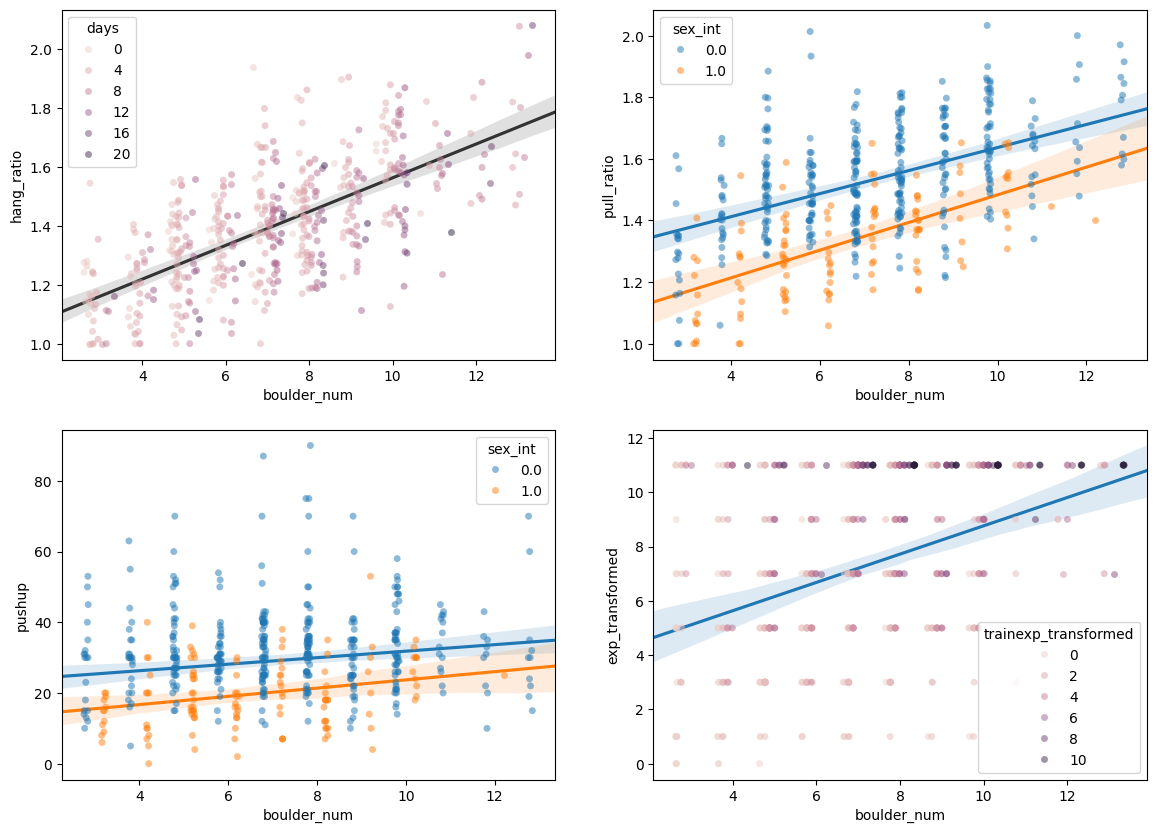

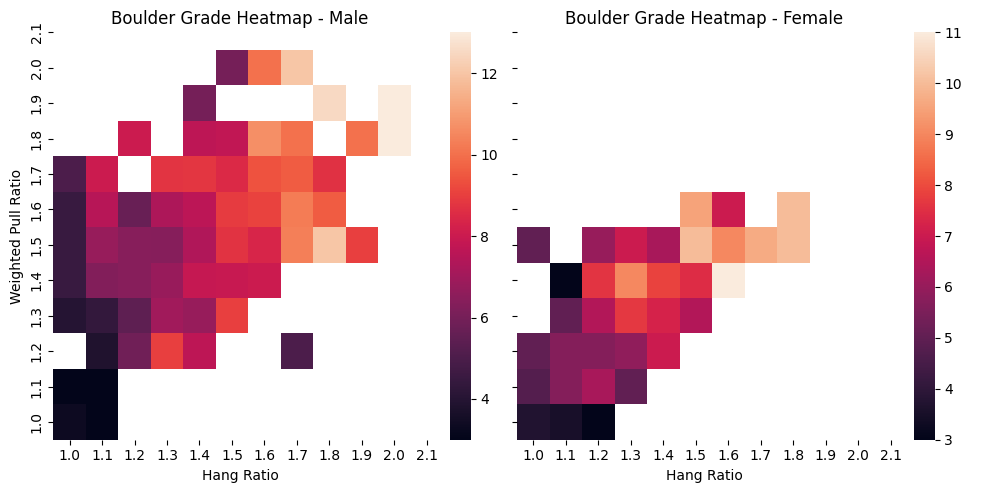

In [349]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10)).tight_layout()
plt.subplot(221)
sns.stripplot(data=clean_data, x="boulder_num", y="hang_ratio", hue="days", alpha=0.5, native_scale=True, dodge=True)
sns.regplot(
    data=clean_data, x="boulder_num", y="hang_ratio", ci=99,
    scatter=False, truncate=False, order=1, color='.2'
)
plt.subplot(222)
sns.stripplot(data=clean_data, x="boulder_num", y="pull_ratio", hue="sex_int", alpha=0.5, native_scale=True, dodge=True)
sns.regplot(
    data=clean_data[clean_data.sex_int == 0], x="boulder_num", y="pull_ratio", ci=99,
    scatter=False, truncate=False, order=1,
)
sns.regplot(
    data=clean_data[clean_data.sex_int == 1], x="boulder_num", y="pull_ratio", ci=99,
    scatter=False, truncate=False, order=1,
)
plt.subplot(223)
sns.stripplot(data=clean_data, x="boulder_num", y="pushup", hue="sex_int", alpha=0.5, native_scale=True, dodge=True)
sns.regplot(
    data=clean_data, x="boulder_num", y="pushup", ci=99,
    scatter=False, truncate=False, order=1,
)
sns.regplot(
    data=clean_data[clean_data.sex_int == 1], x="boulder_num", y="pushup", ci=99,
    scatter=False, truncate=False, order=1,
)
plt.subplot(224)
sns.stripplot(data=clean_data, x="boulder_num", y="exp_transformed", hue="trainexp_transformed", alpha=0.5, native_scale=True, dodge=True)
sns.regplot(
    data=clean_data, x="boulder_num", y="exp_transformed", ci=99,
    scatter=False, truncate=False, order=1,
)
plt.show()

bucketed_data = pd.DataFrame()
bucketed_data["sex_int"] = clean_data.sex_int
bucketed_data["Hang Ratio"] = np.trunc(clean_data['hang_ratio'] * 10) / 10
bucketed_data["Weighted Pull Ratio"] = np.trunc(clean_data['pull_ratio'] * 10) / 10
bucketed_data["Boulder Grade"] = clean_data['boulder_num']

heatmap_data = bucketed_data.pivot_table(index='Weighted Pull Ratio', columns='Hang Ratio', values='Boulder Grade')
titles = ["Boulder Grade Heatmap - Male", "Boulder Grade Heatmap - Female"]

def draw_heatmap(*args, **kwargs):
    num_ticks = 12
    xticks = np.linspace(1.0, 2.1, num_ticks, dtype=float).round(1)
    yticks = np.linspace(1.0, 2.1, num_ticks, dtype=float).round(1)

    data = kwargs.pop('data')
    d = data.pivot_table(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, xticklabels=xticks, yticklabels=yticks, linecolor='white', **kwargs)
    #ax.set_yticks(yticks)
    ax.invert_yaxis()

g = sns.FacetGrid(bucketed_data, col="sex_int", height=5)
g.map_dataframe(draw_heatmap, "Hang Ratio", "Weighted Pull Ratio", "Boulder Grade")
g.add_legend()
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

Setting up our imputation + scaling pipeline

In [350]:
from sklearn.model_selection import train_test_split

col_list = ["height", "weight", "age", "days", "exp_transformed", "trainexp_transformed", "hang_ratio", "pull_ratio", "ape"]
target = "boulder_num"
X = clean_data[col_list].values,
y = clean_data[target].values

# Train test split
print(len(X[0]), len(y))
num_classes = int(max(y) - min(y))
min_class = int(min(y))
class_list = [x + min_class for x in range(num_classes)]
X_train, X_test, y_train, y_test = train_test_split(X[0], y, test_size=0.25, random_state=0, stratify=y)

# Scaling + PCA + imputation
# currently we are only imputing from our used col list
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import HuberRegressor
from sklearn.pipeline import Pipeline

# first we impute values, rounding our categorical / ordinal values to the nearest integer after
# we use robust regression to impute, therefore hopefully reducing the weight of outliers during imputation
cat_cols = [0]
pipe = Pipeline(steps=[('scale', StandardScaler()), ('impute', HuberRegressor())])
imputer = IterativeImputer(estimator=pipe,
                           initial_strategy="median",
                           max_iter=20, random_state=42)

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

512 512


In [351]:
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

from scipy.stats import f

def create_v_labels(start, end):
  return [f"V{x}" for x in range(start, end + 1)]

def plot_regressor(train_preds, preds, y_train, y_test):
    train_residual_diff = np.subtract(y_train.ravel(), train_preds)
    test_residual_diff = np.subtract(y_test.ravel(), preds)
    plt.figure(figsize=(12, 15)).tight_layout()
    plt.subplot(321)
    plt.title("Train Data")
    plt.xlabel("predicted (V-Grade)")
    plt.ylabel("actual (V-Grade)")
    plt.axline((4, 4), slope=1, linestyle='--', color='black')
    plt.axline((4, 5), slope=1, linestyle='--', color='green', alpha=0.5)
    plt.axline((5, 4), slope=1, linestyle='--', color='green', alpha=0.5)
    plt.axline((4, 6), slope=1, linestyle='--', color='red', alpha=0.33)
    plt.axline((6, 4), slope=1, linestyle='--', color='red', alpha=0.33)
    sns.scatterplot(x=train_preds, y=y_train, alpha=0.33)
    plt.subplot(322)
    plt.title("Test Data")
    plt.xlabel("predicted (V-Grade)")
    plt.ylabel("actual (V-Grade)")
    plt.axline((4, 4), slope=1, linestyle='--', color='black')
    plt.axline((4, 5), slope=1, linestyle='--', color='green', alpha=0.5)
    plt.axline((5, 4), slope=1, linestyle='--', color='green', alpha=0.5)
    plt.axline((4, 6), slope=1, linestyle='--', color='red', alpha=0.33)
    plt.axline((6, 4), slope=1, linestyle='--', color='red', alpha=0.33)
    sns.scatterplot(x=preds, y=y_test, alpha=0.33)
    plt.subplot(323)
    plt.xlabel("predicted (V-Grade)")
    plt.ylabel("distance from actual (V-Grade diff)")
    sns.scatterplot(x=train_preds, y=train_residual_diff, alpha=0.33)
    plt.axhline(0, linestyle='--', color='black')
    plt.axhline(1, linestyle='--', color='green', alpha=0.5)
    plt.axhline(-1, linestyle='--', color='green', alpha=0.5)
    plt.axhline(2, linestyle='--', color='red', alpha=0.33)
    plt.axhline(-2, linestyle='--', color='red', alpha=0.33)
    plt.subplot(324)
    plt.xlabel("predicted (V-Grade)")
    plt.ylabel("distance from actual (V-Grade diff)")
    sns.scatterplot(x=preds, y=test_residual_diff, alpha=0.33)
    plt.axhline(0, linestyle='--', color='black')
    plt.axhline(1, linestyle='--', color='green', alpha=0.5)
    plt.axhline(-1, linestyle='--', color='green', alpha=0.5)
    plt.axhline(2, linestyle='--', color='red', alpha=0.33)
    plt.axhline(-2, linestyle='--', color='red', alpha=0.33)
    plt.subplot(325)
    sns.histplot(x=train_residual_diff, kde=True)
    plt.xlabel("Residual Error")
    plt.ylabel("Count")
    plt.subplot(326)
    sns.histplot(x=test_residual_diff, kde=True)
    plt.xlabel("Residual Error")
    plt.ylabel("Count")
    plt.show()


def train_test(model, X_train, X_test, y_train, y_test, graph=True):
    model.fit(X_train, y_train.ravel())
    train_preds = np.clip(model.predict(X_train), 3, 13)
    preds = np.clip(model.predict(X_test), 3, 13)
    rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
    rmse_test = np.sqrt(mean_squared_error(y_test, preds))
    MAE_train = mean_absolute_error(y_train, train_preds)
    MAE_test = mean_absolute_error(y_test, preds)
    acc_train = accuracy_score(np.rint(y_train), np.rint(train_preds))
    acc_test = accuracy_score(np.rint(y_test), np.rint(preds))
    r2_train = r2_score(y_train, train_preds)
    r2_test = r2_score(y_test, preds)
    fstat_train = (r2_train/(1-r2_train))*((X_train.shape[0]-X_train.shape[1]-1)/X_train.shape[1])
    fstat_test = (r2_test/(1-r2_test))*((X_test.shape[0]-X_train.shape[1]-1)/X_train.shape[1])
    p_val_train = f.sf(fstat_train, X_train.shape[0] - 1, X_train.shape[1] - 1)
    p_val_test = f.sf(fstat_test, X_test.shape[0] - 1, X_test.shape[1] - 1)
    Adj_r2_train = 1 - (1-r2_train) * (len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    Adj_r2_test = 1 - (1-r2_test) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print("Train")
    print("-"*15)
    print(f"RMSE: {rmse_train:>10.4f}\nMAE: {MAE_train:>11.4f}\nR^2: {r2_train:>11.4f}\nAdj R^2:  {Adj_r2_train:.4f}\nF value: {fstat_train:>8.4f}")
    print(f"P value: {p_val_train:>8.4f}")
    print("Test")
    print("-"*15)
    print(f"RMSE: {rmse_test:>10.4f}\nMAE: {MAE_test:>11.4f}\nR^2: {r2_test:>11.4f}\nAdj R^2:  {Adj_r2_test:.4f}\nF value: {fstat_test:>8.4f}")
    print(f"P value: {p_val_test:>8.4f}")
    if graph:
        plot_regressor(train_preds, preds, y_train, y_test)

print(f"Dependent variance: {y.var():.4f}")

Dependent variance: 5.5611


Provide a baseline predicting mean model

In [352]:
from sklearn.dummy import DummyRegressor

baseline = DummyRegressor(strategy='mean')
train_test(baseline, X_train, X_test, y_train, y_test, graph=False)

Train
---------------
RMSE:     2.3702
MAE:      1.9314
R^2:      0.0000
Adj R^2:  -0.0241
F value:   0.0000
P value:   1.0000
Test
---------------
RMSE:     2.3221
MAE:      1.8984
R^2:     -0.0015
Adj R^2:  -0.0778
F value:  -0.0191
P value:   1.0000


Now use a linear model, performing testing on the split and ANOVA for the entire dataset

Train
---------------
RMSE:     1.4699
MAE:      1.1755
R^2:      0.6154
Adj R^2:  0.6062
F value:  66.5000
P value:   0.0000
Test
---------------
RMSE:     1.4452
MAE:      1.1916
R^2:      0.6121
Adj R^2:  0.5825
F value:  20.6881
P value:   0.0001


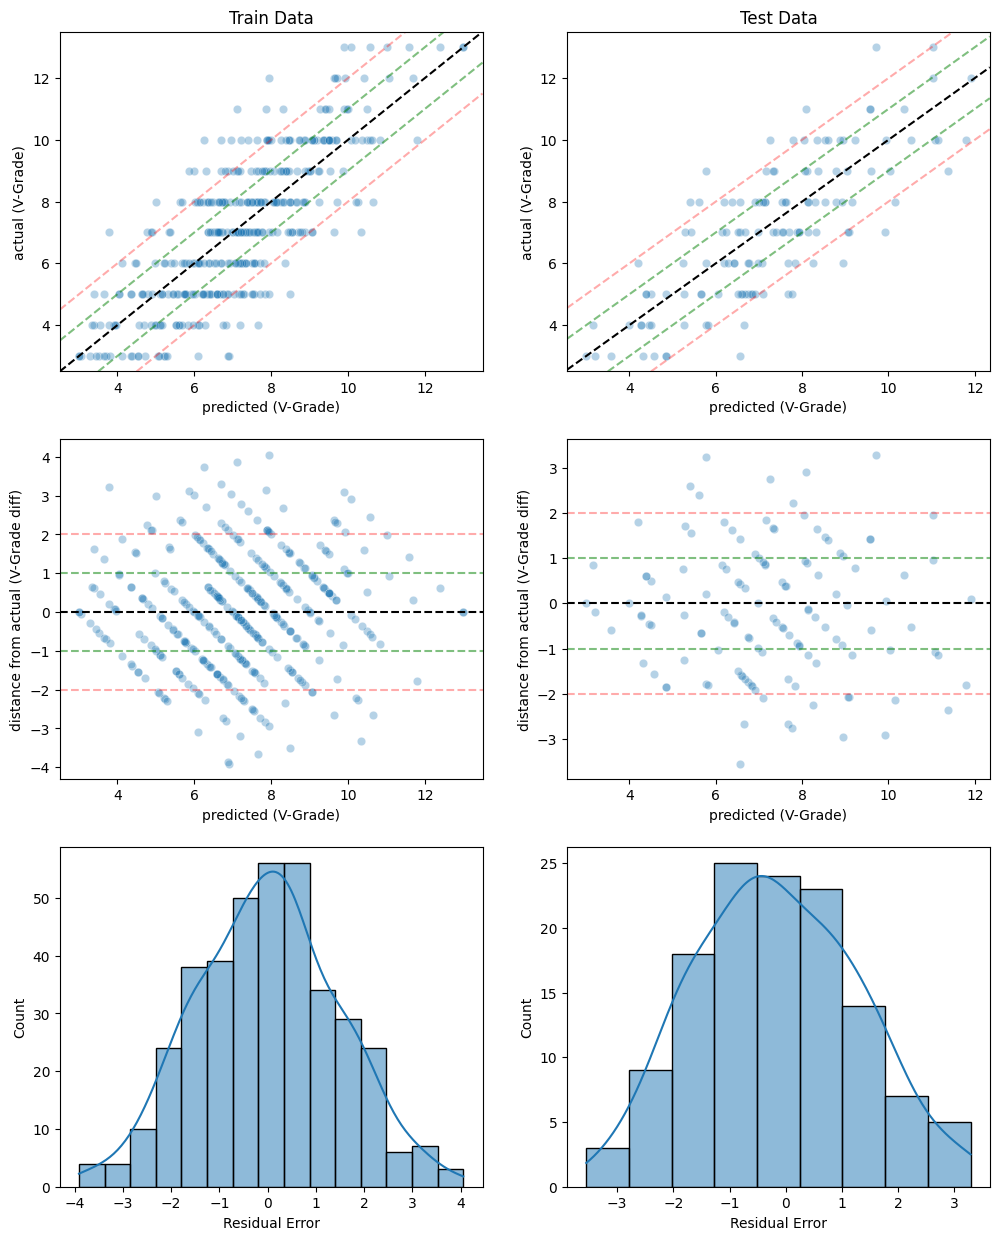

In [353]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
train_test(linear_model, X_train, X_test, y_train, y_test)

# get residuals to plot for the dashboard
test_preds = linear_model.predict(X_test)
d = {"actual y": y_test, 'predicted y': test_preds}
pd.DataFrame(data=d).to_csv("residual_data.csv")

In [354]:
# now we fit our selected model (linear regression) to the entire dataset
full_dataset_imputed = imputer.fit_transform(X[0])
full_dataset_imputed = scaler.fit_transform(full_dataset_imputed)
linear_model.fit(full_dataset_imputed, y)
# print the full model stats on the trained data
train_preds = np.clip(linear_model.predict(full_dataset_imputed), 3, 13)
rmse_train = np.sqrt(mean_squared_error(y, train_preds))
mae_train = mean_absolute_error(y, train_preds)
acc_train = accuracy_score(np.rint(y), np.rint(train_preds))
r2_train = r2_score(y, train_preds)
Adj_r2_train = 1 - (1-r2_train) * (len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print("Full Dataset")
print("-"*15)
print(f"RMSE: {rmse_train:>10.5f}\nMAE: {mae_train:>10.5f}\nR^2: {r2_train:>11.5f}\nAdj R^2: {Adj_r2_train:.5f}\n")

Full Dataset
---------------
RMSE:    1.45777
MAE:    1.17172
R^2:     0.61787
Adj R^2: 0.60867



In [355]:
# now perform an ANOVA-like regression analysis for our OLS model
import statsmodels.api as sm

sm_training_data = sm.add_constant(full_dataset_imputed)

results = sm.OLS(y, sm_training_data).fit().get_robustcov_results()
print(results.summary(xname=['intercept'] + col_list))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     110.8
Date:                Sun, 12 May 2024   Prob (F-statistic):          2.99e-113
Time:                        21:41:50   Log-Likelihood:                -921.33
No. Observations:                 512   AIC:                             1863.
Df Residuals:                     502   BIC:                             1905.
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                7.1445 

Now use our model to try and explain features

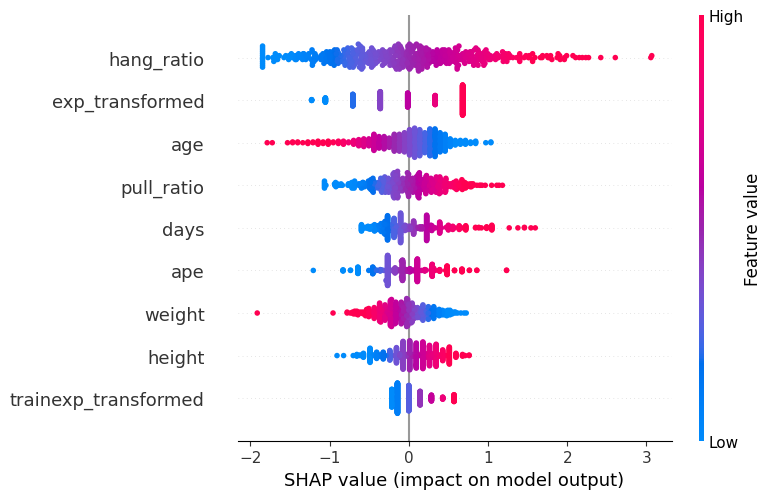

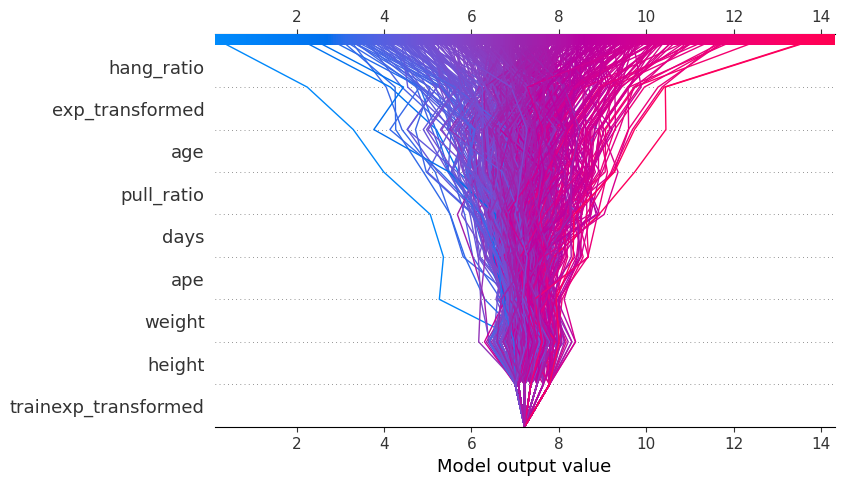

In [356]:
# now get our feature importances and explain
import shap 
X_shap = pd.DataFrame(data = full_dataset_imputed, columns = col_list)
explainer = shap.Explainer(linear_model, full_dataset_imputed)
shap_values = explainer(X_shap)
shap.summary_plot(shap_values)
plt.show()
shap.plots.decision(explainer.expected_value, shap_values.values, X_shap.columns)
plt.show()

Finally, save our linear model

In [357]:
# save and load the linear model piped with the scaling for use in the dashboard
import pickle

pipe_model = Pipeline(steps=[('scale', scaler), ('model', linear_model)])

# save model pipe
with open('model.pkl','wb') as f:
    pickle.dump(pipe_model, f)

# save shap explainer
with open('explainer.pkl','wb') as f:
    pickle.dump(explainer, f)